# MATH 521 - Numerical Analysis of Differential Equations

Christoph Ortner, 01/2024

## Assignment 1 : One Dimension

**Name:** Jincong Li

**Student ID:** 60539939

### Q1: Implementation of  Model Problem [20] 

Recall our first boundary value problem that we studied in class, 
$$ \begin{aligned}
 & - u'' = f, \quad x \in (0, 1), \\ 
 & u(0) = u(1) = 0. 
 \end{aligned}
$$
We reformulated this in the weak form: find $u \in H^1_0(0, 1)$ such that 
$$
   \int_0^1 u' v' dx = \int_0^1 f v dx \qquad \forall v \in H^1_0(0, 1). 
$$
We then defined the finite element method as follows: 
- Specify the nodes for a mesh: $0 = x_0 < x_1 <\dots < x_N = 1$
- Specify the space $V_h = \{ u_h : \text{cts, p.w. affine w.r.t. } (x_j)_j \}$
- Fine $u_h \in V_h$ such that 
$$
  \int_0^1 u_h' v_h' dx = \int_0^1 f v_h dx \qquad \forall v_h \in H^1_0(0, 1). 
$$

**Your task:** Implement this numerical scheme, using mid-point quadrature (as in class) solve it with $f(x) = 1$, plot both the exact solution and the finite element solution (for $N = 15$).

In [1]:
# import Pkg; Pkg.add("Plots")
# import Pkg; Pkg.add("LaTeXStrings")
# using Plots, LaTeXStrings
# import Pkg; Pkg.add("GR")

In [2]:
# outline of the implementation 
using Plots, LaTeXStrings
function assemble_system(X, f)
    # input 
    #   X : list of grid points, e.g. as Vector{Float64}
    #   f : function to evaluate f(x)
   
    N = length(X) - 1    # number of elements
    A = zeros(N+1, N+1)  # should be sparse, but let's not worry
    F = zeros(N+1)
    
    for j = 1:N
        # compute the contributions to F and A from the element (xⱼ₋₁, xⱼ)
        # and write them into A, F 
        ξⱼ = 0.5 * (X[j]+X[j+1])  # midpoint for quadrature
        hⱼ = X[j+1] - X[j]        # mesh size in current element 
        A[j,j] += 1/hⱼ
        A[j+1,j+1] += 1/hⱼ
        A[j,j+1] += -1/hⱼ
        A[j+1,j] += -1/hⱼ 
        F[j] += hⱼ * f(ξⱼ)*0.5    # 0.5 is the value of \phi_i(\Xi_i)
        F[j+1] += hⱼ * f(ξⱼ)*0.5
    end
   
    return A, F
end

# My suggestion is that `assemble_system` returns 
# A and F ignoring the boundary condition i.e. for the full 
# N+1 DOFs. We can then reduce those to the required size 
# for solving only for the free DOFs. (Think about why this works!)

N = 15 
X = range(0, 1, length = N+1)
f = x -> 1.0
A, F = assemble_system(X, f) 
U = zeros(N+1)
U[2:N] = A[2:N, 2:N] \ F[2:N];

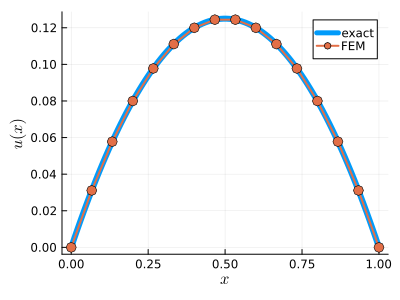

In [3]:
# the postprocessing and visualization should be done in a separate cell
# from the computation. 

xp = range(0, 1, 100)
u = xp -> 0.5 * xp .* (1-xp)

plot(; xlabel = L"x", ylabel = L"u(x)", size = (400, 300))
plot!(xp, u, lw=6, label = "exact")
plot!(X, U, lw=2, m=:o, ms=5, label = "FEM")


---

### Q2-pre [5]

To solve the following question you will need a little extra piece of information that I hinted at in class but didn't really work out completely: in one dimension, point evaluation is a continuous / bounded operation in the typical Sobolev spaces we encounter. Concretely, the following is true: let $\hat{x} \in (0, 1)$ and let $v \in C^1([0, 1])$ then 
$$
  \big| v(\hat{x}) - v(0) \big| \leq C \| v' \|_{L^2(0, 1)} 
$$
for some suitable constant $C > 0$. Prove this statement. 


**Solution for Q2-pre:**
$$
     v(\hat{x}) - v(0)  = \int_{0}^{\hat x}  v^{\prime} (x)  \, dx\
$$

By applying Cauchy-Schwarz Inequality:

$$
    \big| \int_{0}^{\hat x} v^{\prime} (x)  \, dx\ \big| \leq  \sqrt { \big| \int_{0}^{\hat x} 1^2 \,dx \big|}  \cdot  \sqrt { \big| \int_{0}^{\hat x} {(v^{\prime} (x))}^2 \,dx \big|} 
$$

Consider the first term as a positive constant $C$, and then write the second term in the $L^2$ norm format:

$$
    \sqrt { \big| \int_{0}^{\hat x} 1^2 \,dx \big|}  \cdot  \sqrt { \big| \int_{0}^{\hat x} {(v^{\prime} (x))}^2 \,dx \big|} = C {||v^{\prime}||}_{L^2(0,1)}
$$

Therefore, one can conclude 
$$
    \big| v(\hat{x}) - v(0) \big| \leq C {||v^{\prime}||}_{L^2(0,1)}
$$

### Q2: Neumann Boundary Condition [15]

Consider the boundary value problem
$$
\begin{aligned} 
     - u'' &= f, \quad x \in (0, 1), \\ 
    u(0) &= 0, \\ 
    u'(1) &= g.
\end{aligned} 
$$
where $a, f$ are continuous in $[0, 1]$, $a(x) > 0$, $g \in \mathbb{R}$. 

(1) Derive the weak form. Prove that it has a unique solution.

*HINT: the correct function space this time is not $H^1_0(0, 1)$.  Remember from class how we chose the test function!*

(2) Formulate the corresponding finite element method. Prove that it has a unique solution.

(3) Prove that the FEM solution is the best approximation in a natural norm that you should specify. 

**Solution (Q2.1)**
Assume a test function $v(x)$ and by integration by parts:
$$
\begin{align*}
    \int_{0}^{1} u^{\prime}v^{\prime}\ dx\ - u^{\prime}v \big |_{0}^{1} &= \int_{0}^{1} fv\ dx\ \\
    % \text{By appling the Dirichlet and Newmann boundary condition:} \\
    \int_{0}^{1} u^{\prime}v^{\prime}\ dx\ - g \cdot v(1) &= \int_{0}^{1} fv\ dx\ \\
    \int_{0}^{1} u^{\prime}v^{\prime}\ dx\ &= \int_{0}^{1} fv\ dx\ + \int_{{\Gamma}_D} gv\ dx\ \ \forall v \in H_{{\Gamma}_D}^{1}
\end{align*}
$$
One can conclude the first term to be
$$a(u,v)$$
And the second term to be
$$l(v)$$
Thus, the weak form is:
$$a(u,v)=l(v) \ \forall v \in H_{{\Gamma}_D}^{1}$$
To prove the existence and uniqueness of the solution, it is necessary to prove the following statements:

Boundness of $l(v)$:
$$
\begin{align*}
l(v) &= \int_{0}^{1} fv\ dx\ + \int_{{\Gamma}_D} gv\ dx\ \\
\text{Considering the first term}\\
\big | \int_{0}^{1} fv\ dx\ \big | &\leq  {||f||}_{L^2(0,1)} {||v||}_{L^2(0,1)} \leq  {||f||}_{L^2(0,1)} {|v|}_1\\
\text{Then considering the second term} \\
\big | \int_{{\Gamma}_D} gv\ dx\ \big | &\leq {||g||}_{L^2({\Gamma}_D)} {||v||}_{L^2(\partial \Omega)}\\
\text{By Trace theroem}\\
& \leq C_{tr} {||g||}_{L^2({\Gamma}_D)} {||v||}_1 \\
\iff |l(v)| \leq ( {||f||}_{L^2(0,1)} + C_{tr} {||g||}_{L^2({\Gamma}_D)}){||v||}_1
\end{align*}
$$
Thus, the boundedness of $l(v)$ is proved and indicates $ l \in (H_{{\Gamma}_D}^1)^*$.

Boundedness of a:
$$
\begin{align*}
a(u,u) &= \int_{\Omega} \sum_{ik} a_{ik} \partial_i u \partial_k u + a_0 u^2 \ dx\ \\
\text{Considering the first term} \\
\int_{\Omega} \sum_{ik} a_{ik} \partial_i u \partial_k u \ dx\ & \leq c_1 (|\partial u|)^2\\
\text{Considering the second term} \\
\int_{\Omega}  a_0 u^2 \ dx\ & \leq c_1 u^2\\
\text{Thus,}
a(u,u) & \leq c_1 \int_{\Omega}  u^2 + (|\partial u|)^2\ dx\
\end{align*}
$$
So, the boundedness of a is proved.

Coercivity of a: 
$$
\begin{align*}
a(u,u) &= \int_{\Omega} \sum_{ik} a_{ik} \partial_i u \partial_k u + a_0 u^2 \ dx\ \text{assume $a_0 > 0$}\\
& \geq c_0 {||\partial u||}^2_{L^2} = c_0 {|u|}_1^2 \\
\text{By Poincaré's inequality,exists a constant $C_p > 0$ s.t.}\\
\|u\|_{L^2} & \leq C_p \|\partial u\|_{L^2} \ \forall u \in H_{{\Gamma}_D}^{1}\\
\text{Therefore,}\\
a(u,u) & \geq \text{min} (c_0/2,c_0/(2c_p))({||\partial u||}_{L^2}^2 + {||u||}_{L^2}^2)\\
& =: c_0^{\sim} {||u||}_1^2
\end{align*}
$$


And by  Lax-Milgram Theorem:
$a$ is proved to be bilinear, bounded and coercive. $l$ is proved to be linear and bounded
There exist $u\in  H_{{\Gamma}_D}^{1} $ such that $a(u,v)=l(v) v \in  H_{{\Gamma}_D}^{1}$

**Solution (Q2.2)**
 The corresponding discretized form is as follows:
 Suppose N elements in total
 $$
 \begin{align*}
    \int_{0}^{1} u_h^{\prime}v_h^{\prime}\, dx\ &= \int_{0}^{1} fv_h\ dx\ + \int_{{\Gamma}_D} gv_h\, dx\ \ \forall v \in V_h \\
    \iff V^T A U &= V^T F \\
    \iff AU &= F \\
    \text{where} \ A_{ij} &=\int {\phi_i}^{\prime} {\phi_j}^{\prime} \ dx\ = \sum_{n=1}^{N} \int_{x_{n-1}}^{x_n} {\phi_i}^{\prime} {\phi_j}^{\prime} \ dx \\
    F_j &= \int f \phi_j \,dx\  \approx h_j f(\xi_j) \phi(\xi_j) + h_{j+1} f(\xi_{j+1}) \phi(\xi_{j+1})\\
    \text{When $j = N$,}\ F_{j+1} +&= g \\ 
 \end{align*}
 $$
I do not know how to express this in the $F_j$ formula above precisely, but it will be clearly stated in the code-wise statement below.
In terms of for loop:
$$
\begin{align*}
\text{for} \ j &=1,...,N \\
ξ_j &= 0.5 \cdot  (X_j+X_{j+1}) \\
h_j &= X_{j+1} - X_j   \\
F_j +&= h_j f(\xi_j) \phi(\xi_{j-1}) + h_{j+1} f(\xi_{j}) \phi(\xi_{j})\\
\text{When $j = N$,}\ F_{j+1} +&= g \\
A_{j-1,j-1} +&= 1/h_n\\
A_{j,j} +&= 1/h_n\\
A_{j,j-1} +&= -1/h_n\\
A_{j-1,j} +&= -1/h_n\\
\text end for loop \\
U = A / F
\end{align*}

**Solution (Q2.3)**
Suppose $u$ and $u_h$ are the solutions of the variational probelm in $ H_{{\Gamma}_D}^{1}$ and $V_h$. 
Note $V_h \subseteq  H_{{\Gamma}_D}^{1}$.
By definition of $u$ and $u_h$,
$$
\begin{align*}
a(u,v) &= l(v) \ \forall v \in H_{{\Gamma}_D}^{1}\\
a(u_h,v) &= l(v) \ \forall v \in V_h\\
\end{align*}
$$
By Galerkin orthogonality:
$$
\begin{align*}
a(u-u_h,v) &= 0 \ \forall v \in V_h\\
\end{align*}
$$

Let $v_h \in V_h$ with $v=v_h - u_h \in V_h$.
$$
\begin{align*}
\alpha {||u-u_h||}^2_m &\leq a(u-u_h,u-u_h)\\
& = a(u-u_h, u-u_h) + a(u-u_h, v_h-u_h)\\
& \leq C{||u-u_h||}^2_m {||u-v_h||}^2_m \\
\iff \alpha {||u-u_h||}_m &\leq C{||u-v_h||}_m 
\end{align*}
$$
Therefore, in a natural norm sense, $u_h$ is the best approximation of the original problem.

### Q3:  Implementation of Q2 [10]

Implement the method you defined in Q2. Copy-paste your code from Q1 and adapt it. 

*HINT: only a single line needs to be added to the assemble, then the solution script that enforces the boundary condition needs to be adapted suitably.*

Use it to solve the BVP from Q2 with $f = 1$ and $g = -1/2$ and $N = 10$. Plot the exact solution and the FEM solution.

In [4]:
# Solution to Q3

# outline of the implementation 
using Plots, LaTeXStrings
function assemble_system(X, f)
    # input 
    #   X : list of grid points, e.g. as Vector{Float64}
    #   f : function to evaluate f(x)
   
    N = length(X) - 1    # number of elements
    A = zeros(N+1, N+1)  # should be sparse, but let's not worry
    F = zeros(N+1)
    
    for j = 1:N
        # compute the contributions to F and A from the element (xⱼ₋₁, xⱼ)
        # and write them into A, F 
        ξⱼ = 0.5 * (X[j]+X[j+1])  # midpoint for quadrature
        hⱼ = X[j+1] - X[j]        # mesh size in current element 
        A[j,j] += 1/hⱼ
        A[j+1,j+1] += 1/hⱼ
        A[j,j+1] += -1/hⱼ
        A[j+1,j] += -1/hⱼ 
        F[j] += hⱼ * f(ξⱼ) * 0.5  # 0.5 is the value of \phi_i(\Xi_i)
        F[j+1] += hⱼ * f(ξⱼ) * 0.5 
    end
    F[N+1] += g
    return A, F
end

# My suggestion is that `assemble_system` returns 
# A and F ignoring the boundary condition i.e. for the full 
# N+1 DOFs. We can then reduce those to the required size 
# for solving only for the free DOFs. (Think about why this works!)

N = 10 
X = range(0, 1, length = N+1)
f = x -> 1.0
g = -1/2
A, F = assemble_system(X, f) 
U = zeros(N+1)
U[2:N+1] = A[2:N+1, 2:N+1] \ F[2:N+1];  # The #N+1 node is included here so that the Newmann BC is taken into account

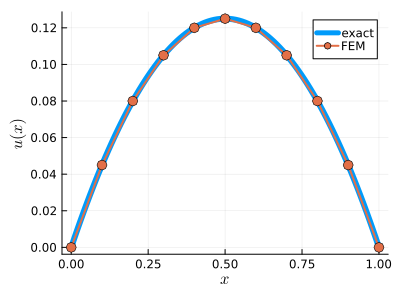

In [5]:
# postprocessing and visualization

xp = range(0, 1, 100)
u = xp -> 0.5 * xp .* (1-xp)
plot(; xlabel = L"x", ylabel = L"u(x)", size = (400, 300))
plot!(xp, u, lw=6, label = "exact")
plot!(X, U, lw=2, m=:o, ms=5, label = "FEM")
# print(U[N])        # Used to check the last value of FEM solution